In [139]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../scripts/')
from PreparaDataset import *

In [9]:
data = pd.read_csv('../../../data/NFL.csv')
data = prepara_df(data)
data = data[data['Date'] < '2023-05-01']

c:\Users\johnn\Documents\venvs\nfl_models\ML\AH_Zebra\v1\../../../scripts\PreparaDataset.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[(_df['Home_Pts'] > _df['Away_Pts']), 'Back_Home'] = 1
c:\Users\johnn\Documents\venvs\nfl_models\ML\AH_Zebra\v1\../../../scripts\PreparaDataset.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.loc[(_df['Back_Home'] == 1), 'PL_Home'] = _df['Odds_H'] - 1
c:\Users\johnn\Documents\venvs\nfl_models\ML\AH_Zebra\v1\../../../scripts\PreparaDataset.py:54: Settin

In [24]:
dataframe = data.copy()

dataframe = dataframe[dataframe['Back_HA_A'] != 2]
dataframe = dataframe[dataframe['HA_Line'] < 0]

In [25]:
div = len(dataframe)
div = 150
treino = dataframe.iloc[:div, :]
val = dataframe.iloc[div: , :]

print(f'Treino: {treino.shape[0]} | Validação: {val.shape[0]}')

Treino: 150 | Validação: 222


In [26]:
print(f"Odd média: {treino['HA_Odds_A'].mean():.2f}")
print(f"WR: {treino['Back_HA_A'].mean():.2f} (Odd justa: {1 / treino['Back_HA_A'].mean():.2f})")
print(f"\nEspaço amostral: {treino.shape[0]}")

Odd média: 1.79
WR: 0.56 (Odd justa: 1.79)

Espaço amostral: 150


In [27]:
features = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under',
       'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P_Diff', 'Porc_Over_Home', 'Porc_Over_Away',
       'Avg_CG_H', 'DP_CG_H', 'CV_CG_H',
       'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'Avg_Retornos_H_Liga', 'Custo_Retorno_H',
       'Avg_Retornos_A_Liga', 'Custo_Retorno_A']

In [28]:
from pycaret.classification import *

cls = setup(data = treino,
        ignore_features = [x for x in treino.columns.to_list() if x not in features and x != 'Back_HA_A'],
        target = 'Back_HA_A',
        train_size = 0.5,
        normalize = True,
        normalize_method = 'zscore',
        session_id = 2023,
        remove_outliers = True,
        verbose = False
            )

xtrain_treino = get_config('X_train')
ytrain_treino = get_config('y_train')
xtrain_teste = get_config('X_test')
ytrain_teste = get_config('y_test')

real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

In [29]:
compare_models(include=['nb', 'lr', 'knn', 'rf', 'gbc', 'et', 'lightgbm', 'svm', 'mlp'], fold = 3, sort='precision')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6000,0.5866,0.6190,0.6602,0.6317,0.1918,0.1969,7.0300
et,Extra Trees Classifier,0.6000,0.5920,0.7143,0.6264,0.6583,0.1733,0.1860,6.0733
gbc,Gradient Boosting Classifier,0.5467,0.5952,0.6429,0.5839,0.6101,0.0691,0.0708,5.7833
svm,SVM - Linear Kernel,0.5333,0.0000,0.6190,0.5796,0.5947,0.0431,0.0432,5.5267
lightgbm,Light Gradient Boosting Machine,0.5333,0.4545,0.6905,0.5735,0.6218,0.0227,0.0211,5.8167
rf,Random Forest Classifier,0.5200,0.5476,0.6190,0.5643,0.5886,0.0134,0.0132,6.9500
mlp,MLP Classifier,0.5200,0.5693,0.5952,0.5623,0.5650,0.0213,0.0234,5.9500
lr,Logistic Regression,0.4933,0.4740,0.6190,0.5421,0.5756,-0.0491,-0.0528,7.0267
nb,Naive Bayes,0.5067,0.5357,0.3810,0.4183,0.3890,0.0494,0.0046,7.1600


Processing:   0%|          | 0/41 [00:00<?, ?it/s]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [52]:
model = create_model('et', cross_validation=False, return_train_score=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.5867,0.5956,0.6429,0.6279,0.6353,0.1585,0.1586
Train,0.9600,0.9971,0.9524,0.9756,0.9639,0.9191,0.9194


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [130]:
def filtra_resultados(_df, filtro = 0):
    _df = _df[(_df['prediction_label'] == 1)]

    if filtro == 1:
        _df = _df[((_df['CV_ML'] >= 0.146))]
        _df = _df[((_df['P_Diff'] < 0.048))]

    return _df

def calcula_profit(_df, stake):
    _df.loc[(_df['Back_HA_A'] == 1), 'PL_BF_Predictions'] = (_df['HA_Odds_A'] - 1) * stake
    _df.loc[(_df['Back_HA_A'] == 0), 'PL_BF_Predictions'] = -stake
    return _df

def exibe_metricas(_df, total, stake):
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df[_df['prediction_label'] == 1].shape[0]
    wr = round((_df[_df['Back_HA_A'] == 1].shape[0] / entradas), 2)
    oddback = _df['HA_Odds_A'].mean()
    med_gain = _df[_df['Back_HA_A'] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df['Back_HA_A'] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
    print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
    print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
    print(f'EM: {ev:.2f}')
    print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')

def exibe_grafico(_df):
    _df.sort_index(inplace=True)
    _df.reset_index(drop=True, inplace=True)
    _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
    _df = _df[_df['prediction_label'] == 1]
    _df['hbacu'].plot.line(figsize=(7,2))
    plt.show()

def treina_modelo(modelo, data):
    _df = predict_model(modelo, data, verbose = False)
    if 'HA_Odds_A_x' in _df.columns.tolist():
        _df.rename(columns={'HA_Odds_A_x': 'HA_Odds_A'}, inplace=True)
        _df.drop(columns='HA_Odds_A_y', inplace=True)

    _df = _df[(_df['prediction_label'] == 1)]
    
    return _df

def info_modelo(modelo, data, stake = 1, filtro = 0):
    total = data.shape[0]
    data = treina_modelo(modelo, data)
    data = filtra_resultados(data, filtro=filtro)
    data = calcula_profit(data, stake)
    exibe_metricas(data, total, stake)
    exibe_grafico(data)
    
    return data


In [ ]:
tuned = tune_model(model, fold=3, optimize='precision', n_iter=50)

In [ ]:
ens_bag = ensemble_model(model, fold = 3, optimize = 'precision', method='Bagging')

In [ ]:
# tuned = tune_model(model, fold = 5, optimize = 'precision', search_library='scikit-optimize', search_algorithm='bayesian', return_train_score=True, n_iter=50)

PL: 20.38 | ROI: 78.38% | Prec.: 1.00
Odd média: 1.78 (0.56 WR)
Média Gain: 0.78 | Média Loss: nan
EM: nan
26 entradas em 75 jogos (34.67%)


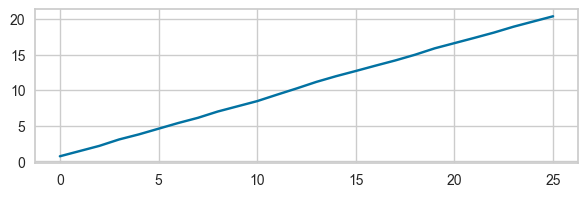

In [131]:
df_treino = info_modelo(model, real_treino, filtro = 1)

PL: 13.06 | ROI: 56.78% | Prec.: 0.87
Odd média: 1.80 (0.56 WR)
Média Gain: 0.80 | Média Loss: -1.00
EM: 0.57
23 entradas em 75 jogos (30.67%)


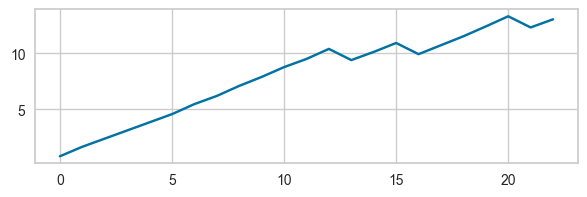

In [132]:
df_teste = info_modelo(ens_bag, real_teste, filtro = 1)

PL: 15.80 | ROI: 28.21% | Prec.: 0.64
Odd média: 1.92 (0.52 WR)
Média Gain: 0.99 | Média Loss: -1.00
EM: 0.28
56 entradas em 222 jogos (25.23%)


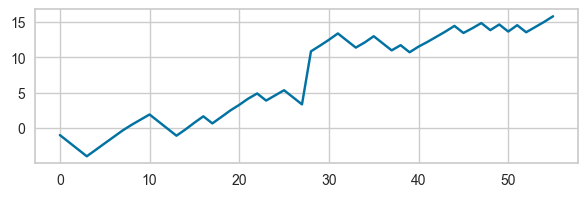

In [133]:
df_val = info_modelo(ens_bag, val, filtro = 1)

PL: 48.24 | ROI: 45.51% | Prec.: 0.77
Odd média: 1.86 (0.54 WR)
Média Gain: 0.88 | Média Loss: -1.00
EM: 0.45
106 entradas em 372 jogos (28.49%)


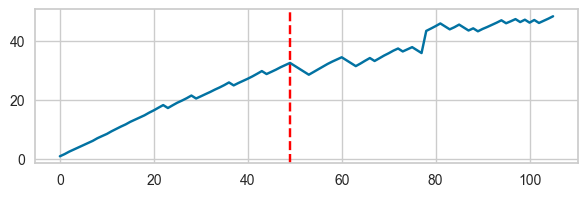

In [134]:
plt.axvline(x=len(df_treino) + len(df_teste), color='red', linestyle='--')
df_completo = info_modelo(ens_bag, dataframe, filtro = 1)

# Validação 2

In [135]:
val2 = pd.read_csv('../../../data/NFL.csv')
val2 = prepara_df(val2)
val2 = val2[val2['Date'] > '2023-05-01']

In [140]:
df_val2

,Date,Season,Season_Time,Time,Home,Away,Home_Pts,Away_Pts,Odds_H,Odds_A,Over_Line,Odds_Over,Odds_Under,HA_Line,HA_Odds_H,HA_Odds_A,Back_Home,PL_Home,Back_Away,PL_Away,Back_Over,Back_Under,PL_Over,PL_Under,Back_HA_H,PL_HA_H,PL_HA_A,P(H),P(A),P(O),P(U),P_Diff,Porc_Over_Home,Porc_Over_Away,CustoGolHome,CustoGolAway,Avg_CG_H,DP_CG_H,CV_CG_H,Avg_CG_A,DP_CG_A,CV_CG_A,MediaCustoGolHome,MediaCustoGolAway,Last_CG_H,Last_CG_A,Acima_Last_CG_H,Acima_Last_CG_A,Abaixo_Last_CG_H,Abaixo_Last_CG_A,CV_ML,CV_Over,Avg_Retornos_H_Liga,Custo_Retorno_H,Avg_Retornos_A_Liga,Custo_Retorno_A,Back_HA_A,prediction_label,prediction_score,PL_BF_Predictions,hbacu
0,2023-09-10,2023,NFL - RODADA 1,14:00,Pittsburgh Steelers,San Francisco 49ers,7.0,30.0,2.01,1.81,41.5,1.90,1.90,-22.0,1.03,14.00,0.0,-1.00,1.0,0.81,0.0,1.0,-1.00,0.90,0.0,-1.00,13.00,0.497512,0.552486,0.526316,0.526316,0.049999,0.333333,0.333333,14.070000,54.299999,33.709999,12.766154,0.378705,31.203333,16.738609,0.536437,31.623333,30.386667,47.599998,16.100000,0.0,0.0,0.0,1.0,0.074043,0.000000,-0.267,-7.528090,-0.046,-43.695652,1.0,1,0.555,13.00,13.000000
1,2023-09-10,2023,NFL - RODADA 1,17:25,Chicago Bears,Green Bay Packers,20.0,38.0,1.81,2.01,41.0,1.91,1.91,-2.5,2.00,1.73,0.0,-1.00,1.0,1.01,1.0,0.0,0.91,-1.00,0.0,-1.00,0.73,0.552486,0.497512,0.523560,0.523560,0.049999,0.333333,0.666667,36.200001,76.379997,41.856667,14.463251,0.345542,51.696667,25.809332,0.499246,59.356667,72.150002,42.900002,65.519997,0.0,0.0,0.0,0.0,0.074043,0.000000,-0.392,-4.617347,0.119,15.210084,1.0,1,0.581,0.73,13.730000
2,2023-09-10,2023,NFL - RODADA 1,14:00,Cleveland Browns,Cincinnati Bengals,24.0,3.0,1.90,1.90,46.5,1.90,1.90,-22.0,1.05,12.00,1.0,0.90,0.0,-1.00,0.0,1.0,-1.00,0.90,0.0,-1.00,11.00,0.526316,0.526316,0.526316,0.526316,0.052632,0.000000,0.000000,45.599998,5.700000,31.293333,16.445320,0.525522,51.766666,29.160894,0.563314,31.296667,53.806667,15.400000,41.000000,0.0,0.0,1.0,0.0,0.000000,0.000000,-0.751,-2.529960,0.669,2.840060,1.0,1,0.561,11.00,24.730000
3,2023-09-10,2023,NFL - RODADA 1,14:00,Minnesota Vikings,Tampa Bay Buccaneers,17.0,20.0,1.47,2.69,44.5,1.90,1.90,-4.5,2.00,1.80,0.0,-1.00,1.0,1.69,0.0,1.0,-1.00,0.90,0.0,-1.00,0.80,0.680272,0.371747,0.526316,0.526316,0.052019,1.000000,0.666667,24.990000,53.799999,38.903332,0.676042,0.017377,42.973331,11.744144,0.273289,45.799999,31.706667,39.599998,53.380001,0.0,0.0,0.0,0.0,0.414745,0.000000,-0.561,-2.620321,0.350,4.200000,1.0,1,0.594,0.80,25.529999
4,2023-09-10,2023,NFL - RODADA 1,14:00,New Orleans Saints,Tennessee Titans,16.0,15.0,1.65,2.25,41.5,1.90,1.90,-3.0,1.90,1.90,1.0,0.65,0.0,-1.00,0.0,1.0,-1.00,0.90,0.0,-1.00,0.90,0.606061,0.444444,0.526316,0.526316,0.050505,0.333333,0.333333,26.400000,33.750000,36.130001,23.278315,0.644293,53.286667,32.656761,0.612851,28.986666,36.613335,10.430000,50.240002,0.0,0.0,1.0,0.0,0.217571,0.000000,-0.561,-2.941176,0.438,3.767123,1.0,1,0.616,0.90,26.429998
5,2023-09-10,2023,NFL - RODADA 1,14:00,Atlanta Falcons,Carolina Panthers,24.0,10.0,1.51,2.57,40.5,1.90,1.90,-4.0,2.00,1.80,1.0,0.51,0.0,-1.00,0.0,1.0,-1.00,0.90,1.0,1.00,-1.00,0.662252,0.389105,0.526316,0.526316,0.051357,0.333333,0.666667,36.240002,25.700001,32.466667,7.635662,0.235185,55.349998,26.459118,0.478033,33.286667,56.226665,41.099998,26.299999,0.0,0.0,0.0,0.0,0.367418,0.000000,-0.396,-3.813131,0.284,5.316901,0.0,1,0.575,-1.00,25.429998
6,2023-09-11,2023,NFL - RODADA 1,21:15,New York Jets,Buffalo Bills,22.0,16.0,2.16,1.70,44.5,1.90,1.90,-21.0,1.04,13.00,1.0,1.16,0.0,-1.00,0.0,1.0,-1.00,0.90,0.0,-1.00,12.00,0.462963,0.588235,0.526316,0.526316,0.051198,0.333333,0.333333,47.520000,27.200001,10.780000,5.730340,0.531571,31.733334,15.972581,0.503338,24.403334,37.380001,4.740000,42.700001,0.0,0.0,1.0,0.0,0.168533,0.000000,-0.374,-5.775401,0.313,6.900959,1.0,1,0.650,12.00,37.430000
7,2023-09-14,2023,NFL - RODADA 2,21:15,Philadelphia Eagles,Minnesota Vikings,34.0,28.0,1.38,3.08,49.0,1.91,1.91,-6.5,1.94,1.86,1.0,0.38,0.0,-1.00,1.0,0.0,0.91,-1.00,0.0,-1.00,0.86,0.724638,0.32

PL: 37.74 | ROI: 134.79% | Prec.: 0.61
Odd média: 3.02 (0.33 WR)
Média Gain: 2.81 | Média Loss: -1.00
EM: 1.32
28 entradas em 46 jogos (60.87%)


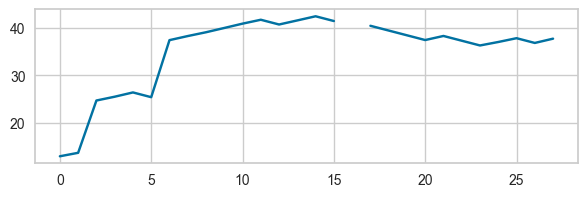

In [137]:
df_val2 = info_modelo(ens_bag, val2, filtro = 0)

# Script qcut

In [124]:
df_cut = df_teste.copy()

In [125]:
for var in features:
    try:
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 4)

        target = 'PL_BF_Predictions'
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        
        pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

        print(var)
        print(pivot_table)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass

Odds_H
                             sum             count     ratio
               PL_BF_Predictions PL_BF_Predictions          
Cat_Odds_H                                                  
(1.179, 1.345]             -0.69                 8 -0.086250
(1.345, 1.475]              5.71                 7  0.815714
(1.475, 1.55]               0.65                 8  0.081250
(1.55, 1.72]                4.09                 7  0.584286




------------------------------------------------



Odds_A
                            sum             count     ratio
              PL_BF_Predictions PL_BF_Predictions          
Cat_Odds_A                                                 
(2.129, 2.46]              2.09                 9  0.232222
(2.46, 2.745]              2.65                 6  0.441667
(2.745, 3.28]              6.61                 8  0.826250
(3.28, 5.1]               -1.59                 7 -0.227143




------------------------------------------------



Over_Line
                 

In [ ]:
_df = _df[((_df['Odds_H'] <= 1.74))]

In [ ]:
# display(df_cut2.groupby('Cat_Last_CG_A')['Last_CG_A'].describe())